# Simulation of Turn of Month Strategy Based on Nifty Next 50 Index Weighted Portfolio

In [1]:
import vectorbt as vbt
import pandas as pd
import numpy as np
from numba import njit
from vectorbt.portfolio import nb
from vectorbt.portfolio.enums import Direction, NoOrder, SizeType


vbt.settings.portfolio["size_granularity"] = 1

In [2]:
# Reading the Data

base_path = "./data/simulation_input/niftynext50/"
documentation_path = "./documentation/niftynext50_iw_"

TurnOfMonthEntry = pd.read_csv(base_path + "master_TurnOfMonthEntry.csv")
TurnOfMonthExits = pd.read_csv(base_path + "master_TurnOfMonthExits.csv")
open_price = pd.read_csv(base_path + "master_open_price.csv")
close_price = pd.read_csv(base_path + "master_close_price.csv")
size_df = pd.read_csv(base_path + "master_weightage.csv")

Set the index as Date and ensure that the entries and exits, are of data type bool and all the dates are of datetime64[ns, UTC+05:30].

In [3]:
TurnOfMonthEntry.Date = pd.to_datetime(TurnOfMonthEntry.loc[:, "Date"])
TurnOfMonthExits.Date = pd.to_datetime(TurnOfMonthExits.loc[:, "Date"])
open_price.Date = pd.to_datetime(open_price.loc[:, "Date"])
close_price.Date = pd.to_datetime(close_price.loc[:, "Date"])

TurnOfMonthEntry = TurnOfMonthEntry.set_index("Date")
TurnOfMonthExits = TurnOfMonthExits.set_index("Date")
open_price = open_price.set_index("Date")
close_price = close_price.set_index("Date")

for symbol in TurnOfMonthEntry.columns:
    TurnOfMonthEntry[symbol] = TurnOfMonthEntry[symbol].astype(bool)

for symbol in TurnOfMonthExits.columns:
    TurnOfMonthExits[symbol] = TurnOfMonthExits[symbol].astype(bool)

## Simulation logic:

    Buy at open on the last trading day of the month.
    Sell at close on the third trading day of the next month. 

Since it is an equal weight simulation and there are 50 companies on the index at any given point of time.

The weight of each company in the portfolio would be 2%.

Also, initial cash is 5,00,000 INR.

In [4]:
@njit
def order_func_nb(c, entries, exits, size, open_price):

    # Select info related to this order
    entry_now = nb.get_elem_nb(c, entries)
    exit_now = nb.get_elem_nb(c, exits)
    size_now = nb.get_elem_nb(c, size)
    close_price = nb.get_elem_nb(c, c.close)
    open_price = nb.get_elem_nb(c, open_price)

    if entry_now:
        if c.position_now == 0:

            return nb.order_nb(
                size=size_now,
                price=open_price,
                direction=Direction.LongOnly,
                size_type=SizeType.TargetPercent,
                size_granularity= 1,
                min_size=1,
            )

    elif exit_now:
        if c.position_now > 0:
            return nb.order_nb(
                size=-c.position_now,
                price=close_price,
                direction=Direction.LongOnly,
                size_type=SizeType.TargetPercent,
                size_granularity=1,
                min_size=1,
            )

    return NoOrder


def simulate(open_price, close_price, entries, exits, size=0.02, group_by = False, cash_sharing = False, init_cash = 10000):

    return vbt.Portfolio.from_order_func(
        close_price,
        order_func_nb,
        vbt.Rep("entries"),
        vbt.Rep("exits"),
        vbt.Rep("size"),
        vbt.Rep("open_price"),
        init_cash=init_cash,
        cash_sharing=cash_sharing,
        group_by=group_by,
        broadcast_named_args=dict(  # broadcast against each other
            entries=entries, exits=exits, size=size, open_price=open_price
        ),
    )

## Simulation

In [5]:
pf = simulate(
    open_price=open_price,
    close_price=close_price,
    entries=TurnOfMonthEntry[open_price.columns],
    exits=TurnOfMonthExits[open_price.columns],
    size=size_df[open_price.columns],
    group_by=True,
    cash_sharing=True,
    init_cash=500000,
)

In [6]:
print("Total Returns: ", str(pf.total_return() * 100) + "%")
print("Total Annualized Return: ", str(pf.annualized_return(freq="d") * 100) + "%")
print("Total Annualized Volatility: ", str(pf.annualized_volatility(freq="d") * 100) + "%")

Total Returns:  733.3701635630052%
Total Annualized Return:  22.78710094252867%
Total Annualized Volatility:  11.850285453364542%


Monthly Returns

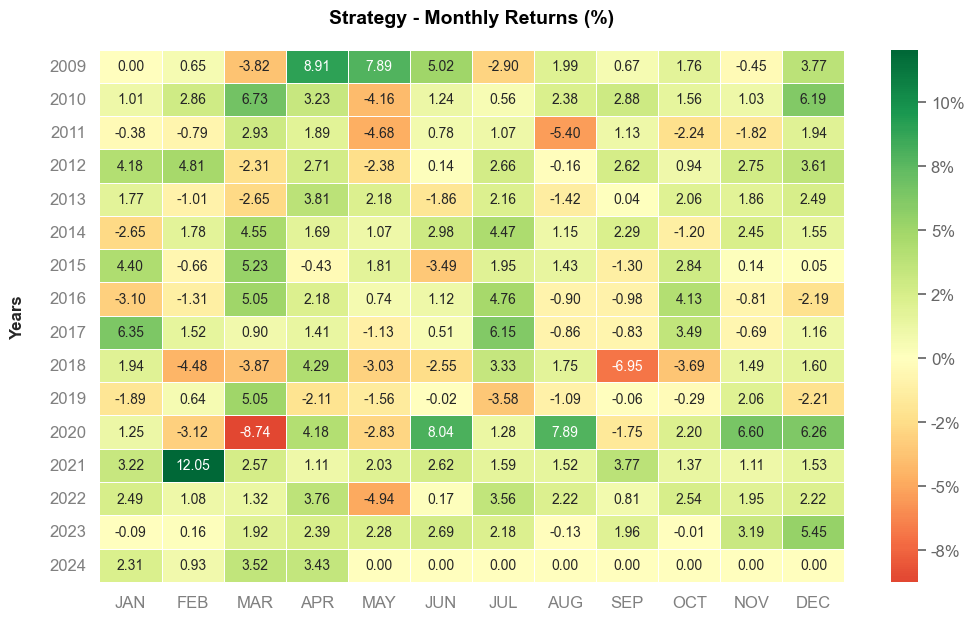

In [7]:
pf.qs.plot_monthly_heatmap()

Yearly Returns

In [8]:
temp = pd.DataFrame(pf.daily_returns()).reset_index()
temp.loc[:,"Year"] = temp.Date.dt.year
temp.fillna(0, inplace=True)
temp.groupby(by="Year").group.sum() * 100

c:\Users\saiha\anaconda3\envs\qfin\lib\site-packages\vectorbt\generic\accessors.py:578: FutureWarning: The 'axis' keyword in Series.resample is deprecated and will be removed in a future version.
  resampled = self.obj.resample(freq, axis=0, **kwargs)


Year
2009    23.174790
2010    25.353262
2011    -5.646616
2012    19.449273
2013     9.541411
2014    20.045922
2015    12.458007
2016     8.823612
2017    17.795102
2018   -10.253796
2019    -4.955207
2020    20.533114
2021    33.959734
2022    17.092020
2023    21.849546
2024    10.129358
Name: group, dtype: float64

In [9]:
pf.plot_value().write_image(engine="orca", file= documentation_path + "value.png")
pf.plot_value()

FigureWidget({
    'data': [{'hoverinfo': 'skip',
              'line': {'color': 'rgba(0, 0, 0, 0)', 'width': 0},
              'opacity': 0,
              'showlegend': False,
              'type': 'scatter',
              'uid': '8de00954-b8bb-4cbc-9cfc-7a5798065229',
              'x': array([datetime.datetime(2009, 1, 1, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
                          datetime.datetime(2009, 1, 2, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
                          datetime.datetime(2009, 1, 5, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
                          ...,
                          datetime.datetime(2024, 4, 26, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
                          datetime.datetime(2024, 4, 29, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
                          datetime.datetime(2024, 4, 30, 0, 0, tzinfo=datet

In [10]:
pf.plot_drawdowns().write_image(engine="orca", file=documentation_path + "drawdowns.png")
pf.plot_drawdowns()

FigureWidget({
    'data': [{'line': {'color': '#9467bd'},
              'name': 'Value',
              'showlegend': True,
              'type': 'scatter',
              'uid': 'f2205002-f198-4871-b705-42ac43da80e7',
              'x': array([datetime.datetime(2009, 1, 1, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
                          datetime.datetime(2009, 1, 2, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
                          datetime.datetime(2009, 1, 5, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
                          ...,
                          datetime.datetime(2024, 4, 26, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
                          datetime.datetime(2024, 4, 29, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
                          datetime.datetime(2024, 4, 30, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800)))],
   

In [11]:
pf.plot_underwater().write_image(engine="orca", file=documentation_path + "underwater.png")
pf.plot_underwater()

FigureWidget({
    'data': [{'fill': 'tozeroy',
              'fillcolor': 'rgba(220,57,18,0.3000)',
              'line': {'color': '#dc3912'},
              'name': 'Drawdown',
              'showlegend': True,
              'type': 'scatter',
              'uid': '04e11f1a-207f-496f-b188-1921a215c7a3',
              'x': array([datetime.datetime(2009, 1, 1, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
                          datetime.datetime(2009, 1, 2, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
                          datetime.datetime(2009, 1, 5, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
                          ...,
                          datetime.datetime(2024, 4, 26, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
                          datetime.datetime(2024, 4, 29, 0, 0, tzinfo=datetime.timezone(datetime.timedelta(seconds=19800))),
                          datetime.datet

Return Stats

In [12]:
pf.returns_stats(settings=dict(freq="d", risk_free=0.000192))

c:\Users\saiha\anaconda3\envs\qfin\lib\site-packages\vectorbt\returns\accessors.py:902: UserWarning:

Changing the frequency will create a copy of this object. Consider setting it upon object creation to re-use existing cache.



Start                        2009-01-01 00:00:00+05:30
End                          2024-04-30 00:00:00+05:30
Period                              3770 days 00:00:00
Total Return [%]                            733.370164
Benchmark Return [%]                       3020.021607
Annualized Return [%]                        22.787101
Annualized Volatility [%]                    11.850285
Max Drawdown [%]                             26.788376
Max Drawdown Duration                713 days 00:00:00
Sharpe Ratio                                   1.20071
Calmar Ratio                                  0.850634
Omega Ratio                                   1.234623
Sortino Ratio                                 2.733352
Skew                                         -0.342293
Kurtosis                                     16.484373
Tail Ratio                                    1.456171
Common Sense Ratio                             1.78799
Value at Risk                                -0.007009
Alpha     

In [13]:
pf.stats(settings=dict(freq="d", risk_free=0.000192))

c:\Users\saiha\anaconda3\envs\qfin\lib\site-packages\vectorbt\generic\stats_builder.py:262: UserWarning:

Changing the frequency will create a copy of this object. Consider setting it upon object creation to re-use existing cache.



Start                         2009-01-01 00:00:00+05:30
End                           2024-04-30 00:00:00+05:30
Period                               3770 days 00:00:00
Start Value                                    500000.0
End Value                                4166850.817815
Total Return [%]                             733.370164
Benchmark Return [%]                        3020.021607
Max Gross Exposure [%]                        99.999956
Total Fees Paid                                     0.0
Max Drawdown [%]                              26.788376
Max Drawdown Duration                 713 days 00:00:00
Total Trades                                       7399
Total Closed Trades                                7349
Total Open Trades                                    50
Open Trade PnL                                      0.0
Win Rate [%]                                  62.511906
Best Trade [%]                               798.689361
Worst Trade [%]                              -89